In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../clean2/'
dst = '../watershed/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc2 = ndimage.generate_binary_structure(3, 3)

ssrange = [150,200,250,300,350]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]

fs = 15

walnut_batch = sorted(glob.glob( src + '*/' ))
bidx = 0
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))
bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
wdstd = wdst + 'diagnostic/'
if not os.path.isdir(wdstd):
    os.makedirs(wdstd)
wdsts = wdst + 'snaps/'
if not os.path.isdir(wdsts):
    os.makedirs(wdsts)
print(wdsts)

../watershed/2014SBa_R1_T25/snaps/


In [87]:
widx = 1
print(walnut_files[widx])
img = tf.imread(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

mxval = 2**(8*img.itemsize)-1

../clean2/2014SBa_R1_T25/2014SBa_R1_T25_002.tif
2014SBa_R1_T25_002


# Meat

In [88]:
mimg = img.copy()

eimg = ndimage.binary_erosion(mimg, struc2, 15, border_value=1)
mimg = eimg*mimg
mimg = ndimage.uniform_filter(mimg)

mimg[mimg < 120] = 0

In [89]:
minim = ndimage.minimum_filter(mimg, size=7)

minimv = minim.flatten()
minimv = minimv[minimv > 0]

meanv = np.mean(minimv)
sdv = np.std(minimv)

print('Minimum ', meanv, sdv, meanv-2.25*sdv, sep='\t')

tminim = minim.copy()
tminim[tminim < meanv-2.25*sdv] = 0
tminim[tminim > 230] = 0

Minimum 	149.032545659704	9.1727590817909	128.39383772567447


In [90]:
eimg = ndimage.binary_erosion(tminim, struc2, 2, border_value=1)
eimg = wnut.get_largest_element(eimg, 0.01)

5 components	 1 preserved
[7930141      32       9       3       1]


In [91]:
dimg = ndimage.binary_dilation(eimg, struc2, 6, border_value=0)

if True:
    dimg = ndimage.binary_dilation(dimg, struc1, 4, border_value=0)
    dimg = ndimage.binary_erosion(dimg, struc1, 4, border_value=1)

meat = (dimg*img).copy()
meat[meat < 100] = 0

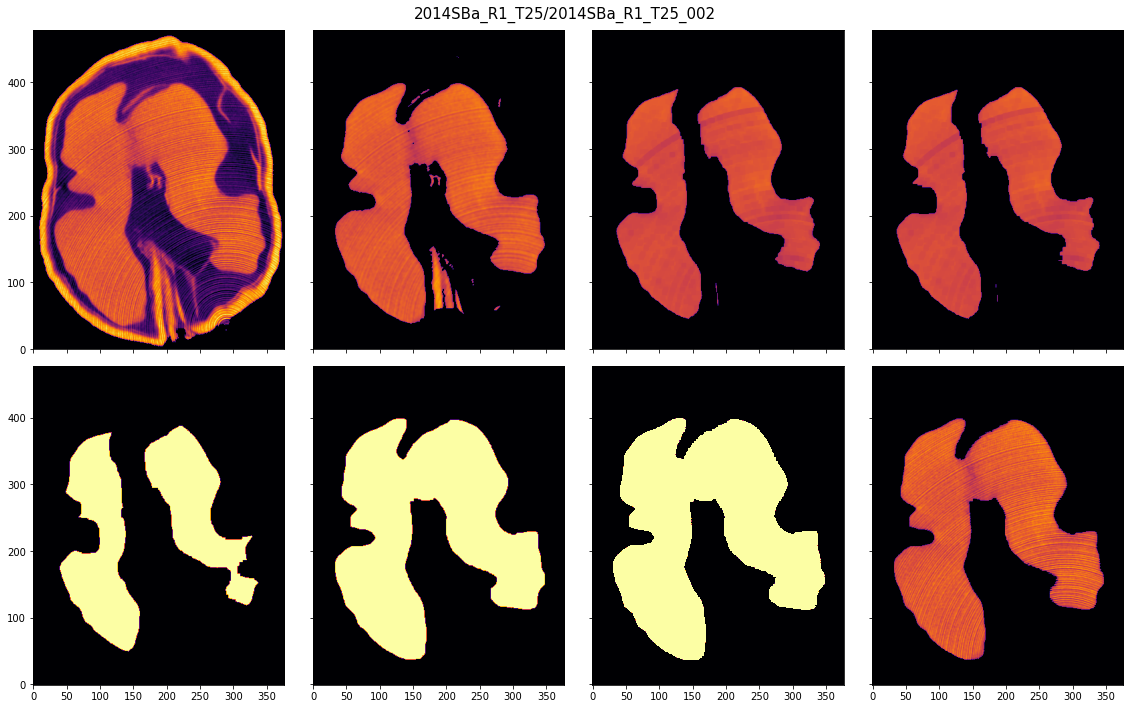

In [92]:
k = 220
ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(mimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 2
ax[i].imshow(minim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 3
ax[i].imshow(tminim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 4
ax[i].imshow(eimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 5
ax[i].imshow(dimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

# Shell

In [93]:
dist = ndimage.distance_transform_cdt(img, 'taxicab')

In [94]:
bshell = (img > 120) & (dist < 7)

In [95]:
timg = img.copy()
timg[timg == 0] = mxval
timg[meat > 0] = 0

timg = ndimage.binary_erosion(timg, struc2, 5, border_value=1)

timg[img < 100] = 0

In [96]:
#eimg = ndimage.binary_erosion(timg, struc2, 3, border_value=1)
eimg = wnut.get_largest_element(timg)
#eimg = ndimage.binary_dilation(eimg, struc2, 1, border_value=0)

2284 components	 1 preserved
[9353422    2092    1156     454     301     196     183     159     158
     144     140     103     101      86      84      79      64      58
      39      38]


In [97]:
cshell = img*eimg
cshell[cshell < 180] = 0
cshell = wnut.get_largest_element(cshell)
cshell[cshell > 0] = 1

2540 components	 1 preserved
[5225493    1526    1353     881     383     376     317     298     221
     217     201     190     185     182     182     171     153     138
     136     119]


In [98]:
dshell = ndimage.binary_dilation(cshell, struc2, 2, border_value=0)
dshell = ndimage.binary_erosion(dshell, struc2, 2, border_value=1)

In [99]:
mshell = cshell | bshell
shell = (img*mshell).copy()

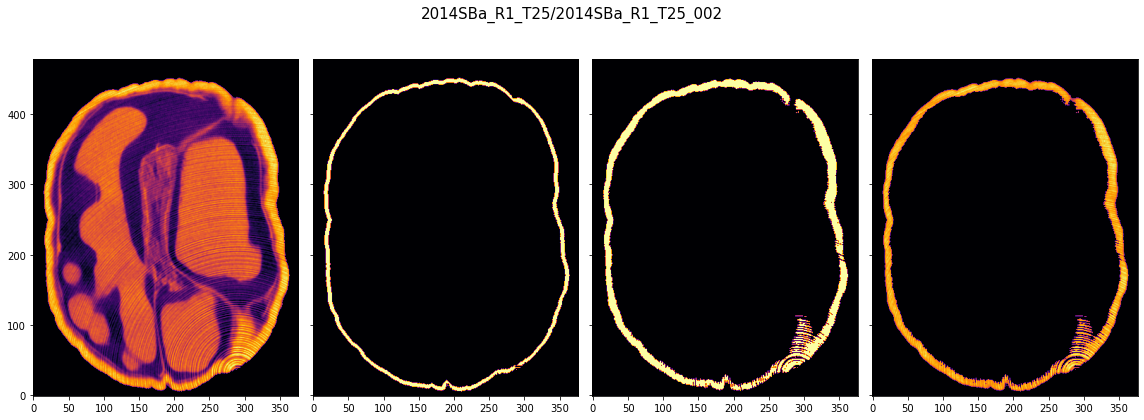

In [100]:
k = 250
ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(bshell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(cshell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Veins

In [101]:
vimg = img.copy()
vimg[meat > 0] = 0
#vimg = ndimage.binary_erosion(vimg, struc1, 1, border_value=1)

vimg[shell > 0] = 0
vimg = ndimage.binary_erosion(vimg, struc1, 2, border_value=1)

In [102]:
vein = img*vimg
vein[vein < 85] = 0
vein[vein > 190] = 0

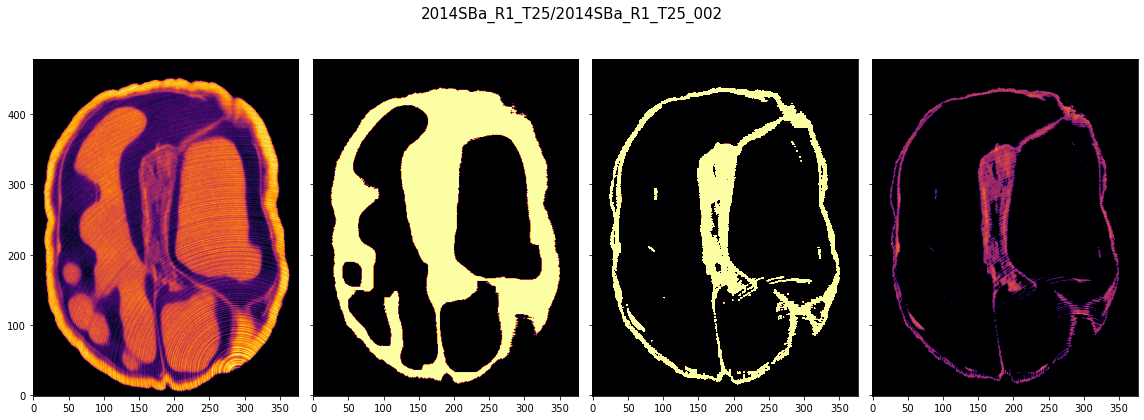

In [103]:
k = 250
ss = np.s_[:,k,:]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(vimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(vein[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(vein[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Air

In [104]:
aimg = img.copy()

aimg[img > 60] = 0
aimg[meat > 0] = 0
aimg[shell > 0] = 0
aimg[vein > 0] = 0
aimg[aimg > 0] = 1

#aimg = ndimage.binary_erosion(aimg, struc2, 2, border_value=1)
#aimg = wnut.get_largest_element(aimg)

In [105]:
air = img*aimg

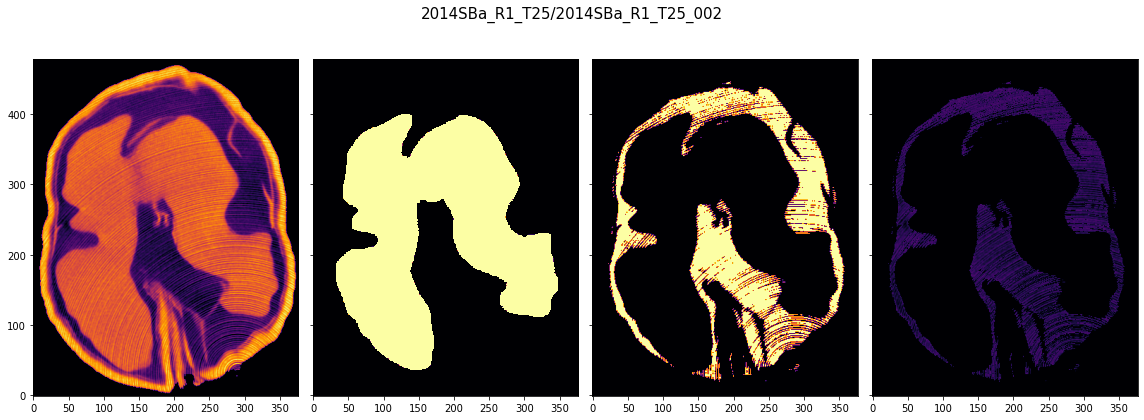

In [106]:
k = 220
ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(aimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(air[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Watershed

In [107]:
markers = np.copy(img).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

for i,tissue in enumerate([meat,shell,vein,air]):
    markers[tissue > 0] = i+1
    
ift = ndimage.watershed_ift(img, markers)

In [108]:
tissues = [None for x in range(4)]
for i in range(len(tissues)):
    mask = ift == i+1
    box = img.copy()
    box[~mask] = 0
    
    tissues[i] = box

# Save and plot

In [109]:
tissue = ['meat','shell','vein','air']

for i in range(len(tissue)):
    filename = wdst + fname + '_' + tissue[i] + '.tif'
    tf.imwrite(filename, tissues[i], photometric='minisblack', compress=3)
    #print(filename)

In [110]:
for i in range(len(tissue)):
    snaps = wnut.collapse_dimensions(tissues[i])
    wnut.plot_collapse_dimensions(snaps, fname, tissue[i], dst=wdsts, writefig=True, display=False)

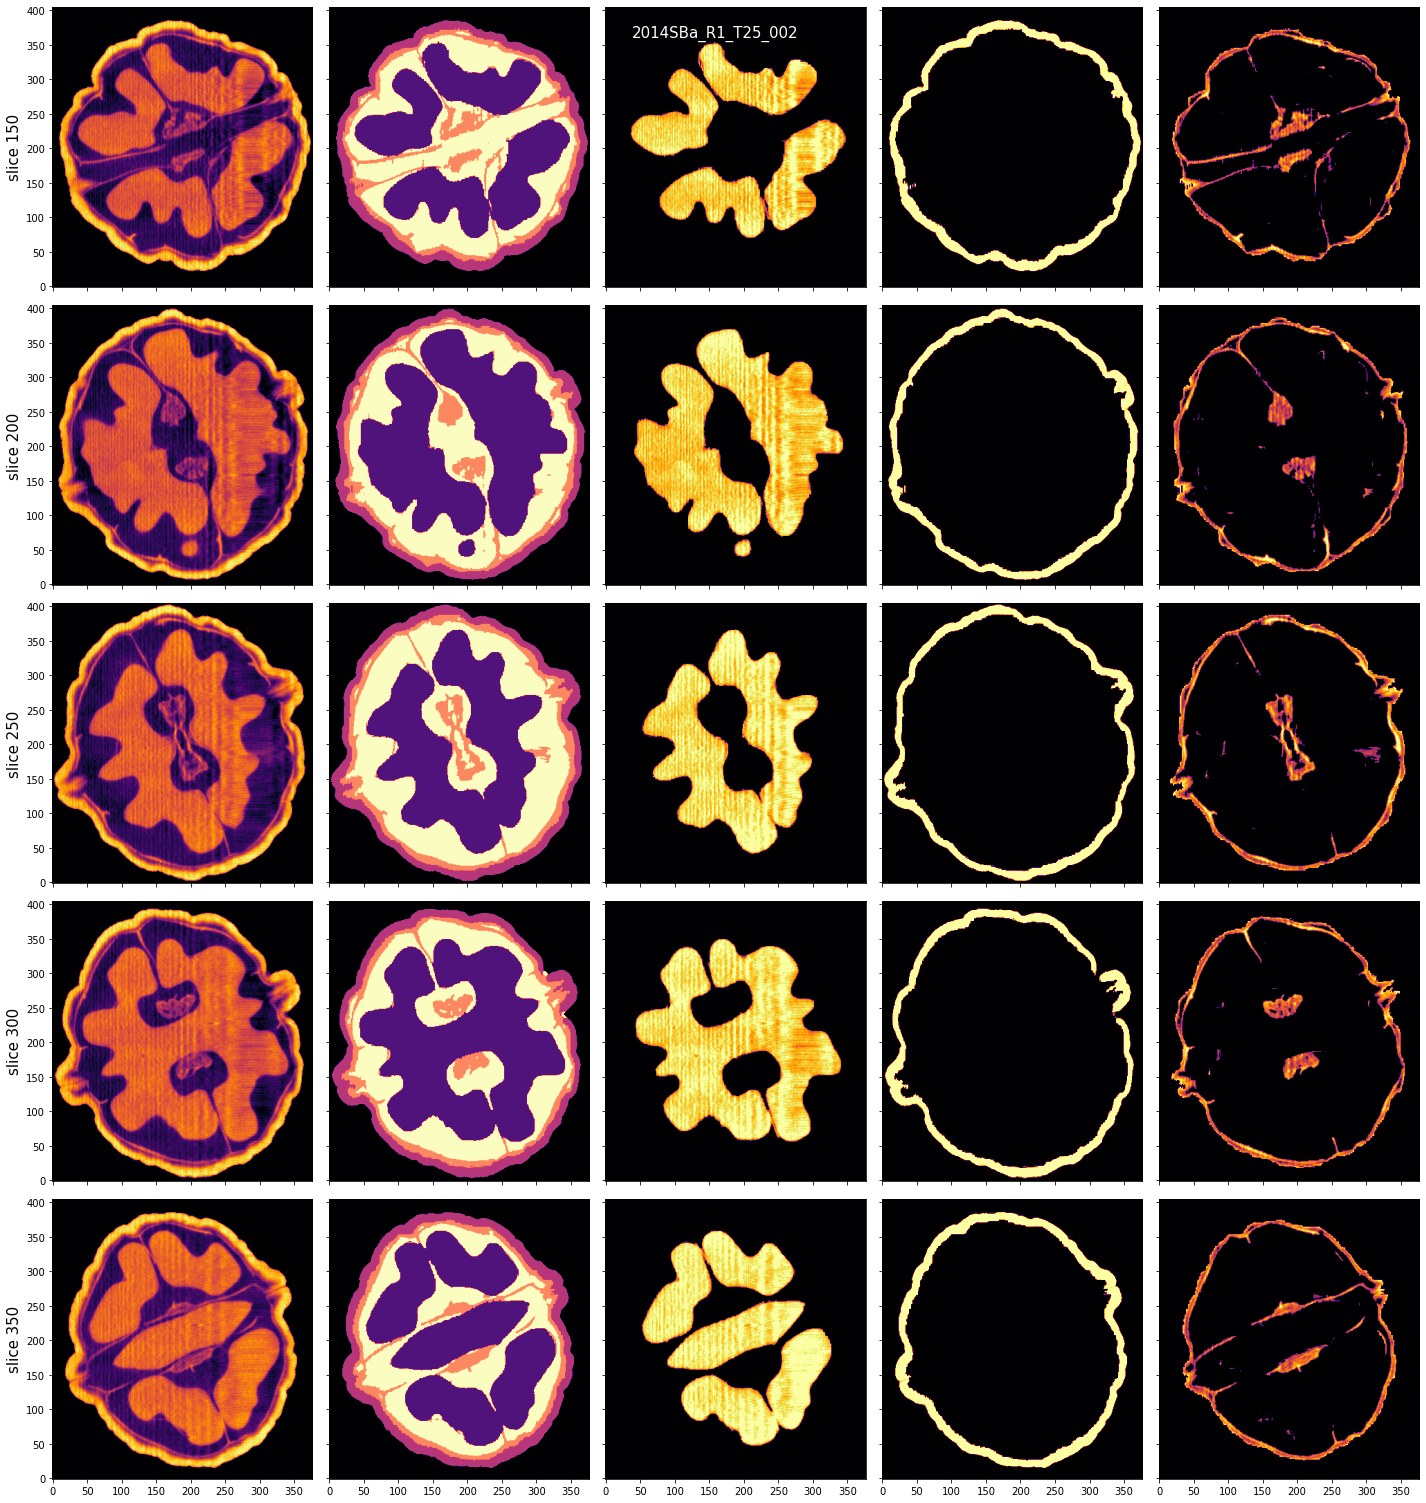

In [111]:
k = 200

ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

j = 0
ss = Sx[j]
    
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).flatten()
for j in range(5):
    ss = Sx[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_x.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
#plt.close()

In [112]:
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
for j in range(5):
    ss = Sy[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_y.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

In [113]:
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
for j in range(5):
    ss = Sz[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_z.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()